# Name ideas?
* PTA
* MeTime
* sonny


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import ipyparallel as ipp
import matplotlib.pyplot as plt
import momi
import numpy as np
import os
import pandas as pd
import time

from IPython.display import display

import PTA


/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# ipcluster start --n=4 --cluster-id="PTA" --daemonize
ipyclient = ipp.Client(cluster_id="PTA")
len(ipyclient)

4

# Build a demographic model

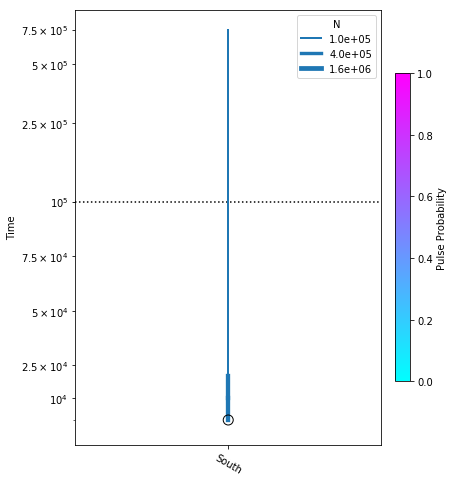

In [33]:
model = momi.DemographicModel(N_e=1e6)
model.add_leaf("South")
#model.add_time_param("texp")
model.set_size("South", t=20000, N=1e5)

yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5]

fig = momi.DemographyPlot(
    model, 
    ["South"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5)

# Simulate

In [4]:
model = PTA.DemographicModel("watdo")
msfs_list = model.serial_simulate(nsims=2, quiet=False, verbose=False)

  [####################] 100%  Finished 2 simulations in   0:00:00 | 
 

# Look at the results

In [18]:
sim_df = pd.read_csv("PTA/default_PTA/SIMOUT.csv", sep=" ").head(500)
sim_df.head()

,zeta,psi,pop0-[[1_3]],pop0-[[2_2]],pop0-[[3_1]],pop1-[[1_3]],pop1-[[2_2]],pop1-[[3_1]],pop2-[[1_3]],pop2-[[2_2]],...,pop6-[[3_1]],pop7-[[1_3]],pop7-[[2_2]],pop7-[[3_1]],pop8-[[1_3]],pop8-[[2_2]],pop8-[[3_1]],pop9-[[1_3]],pop9-[[2_2]],pop9-[[3_1]]
0,0.333,1,12,23,27,18,19,24,11,22,...,53,11,12,26,15,27,51,12,13,34
1,0.782,1,1,3,13,1,3,27,2,5,...,19,4,6,21,2,6,32,4,3,17
2,0.878,2,10,23,29,12,17,35,16,16,...,30,6,6,20,3,19,36,11,27,30
3,0.041,0,4,2,17,5,12,35,8,7,...,25,5,10,32,10,20,54,7,12,31
4,0.362,1,12,14,26,6,7,35,12,9,...,29,1,4,18,5,10,36,2,5,12


# Some simple plotting routines

/home/isaac/miniconda2/envs/momi-py36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


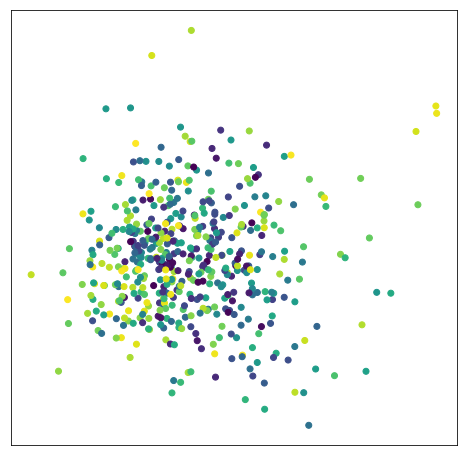

In [38]:
sim_df = pd.read_csv("PTA/default_PTA/SIMOUT.csv", sep=" ").head(500)
PTA.plotting.plot_simulations_pca(sim_df)

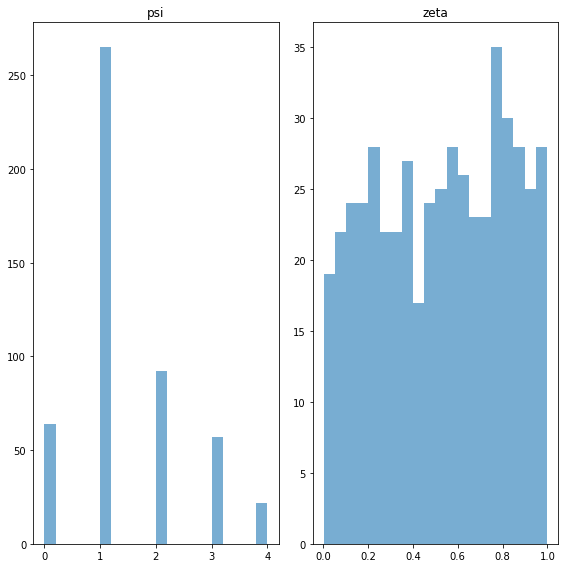

In [40]:
axs = PTA.plotting.plot_simulations_hist(sim_df)

# ML Inference

# Trash below here

In [1069]:
## Simulated empirical

def get_sfs(name, N_e=1e6, t=20000, exp_magnitude=10, verbose=False):
    model = momi.DemographicModel(N_e=N_e)
    model.add_leaf(name)
    model.set_size(name, t=t, N=N_e/exp_magnitude)
    sampled_n_dict={name:4}
    if verbose: print(sampled_n_dict)
    ac = model.simulate_data(length=100,
                            num_replicates=100,
                            recoms_per_gen=1e-9,
                            muts_per_gen=1e-8,
                            sampled_n_dict=sampled_n_dict)
    return ac.extract_sfs(n_blocks=1)

south_sfs = get_sfs("South")
north_sfs = get_sfs("North")
central_sfs = get_sfs("Central", exp_magnitude=1)
np.array([south_sfs.loc_counts, central_sfs.loc_counts, north_sfs.loc_counts])

array([[[  9.,  51.,  15.]],

       [[378., 122., 220.]],

       [[ 21.,  54.,  13.]]])

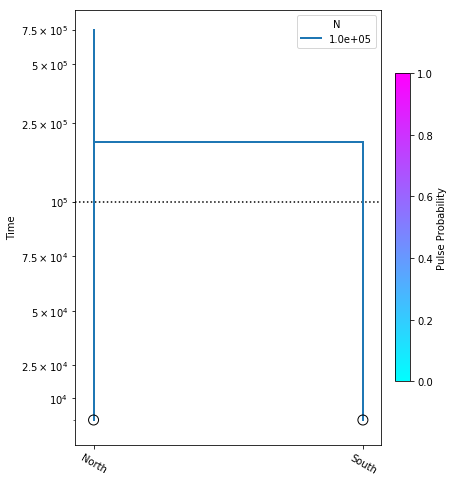

In [3]:
model = momi.DemographicModel(N_e=1e5)
model.add_leaf("North")
model.add_leaf("South")
model.move_lineages("South", "North", t=2e5)

yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5]

fig = momi.DemographyPlot(
    model, 
    ["North", "South"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5)

In [13]:
sampled_n_dict={"North":4, "South":4}
ac = model.simulate_data(length=100,
                    num_replicates=1000,
                    recoms_per_gen=1e-9,
                    muts_per_gen=1e-8,
                    sampled_n_dict=sampled_n_dict)